In [1]:
# first some necessary python imports
import numpy as np
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from models import WilkensLET

In [2]:
def plot_with_error_band(ax, x, y, err,label="", xlabel="z [cm]", ylabel="LET [keV/um]"):
    """helper function to simplify plotting"""
    p = ax.plot(x, y, label=label)
    ax.fill_between(x, y, y+err, color=p[0].get_color())
    ax.fill_between(x, y, y-err, color=p[0].get_color())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

## SHIELD-HIT12A LET calculations

### Pencil beam simulation

 - Energy: 60 MeV
 - Energy spread: 0.5 MeV
 - Point-like source in vacuum
 - Cylindrical liquid water target (R=10cm, L=4cm)
 - DELTAE = 0.005
 - scoring dLET for protons only (the newer, better one) in cylindrical slabs 0.1mm thick (400 slabs on 4cm) of various radius
 - $2000000 \cdot 250 = 5 \cdot 10^8$ particles

In [3]:
# let's load SH12A data
ave_metadata = { 'd' : 'd', 't' : 't'}
filter_metadata = { 'all' : 'a', 'prot' : ''}
radius_metadata = { 10 : '1', 1 : '0p1', 0.1 : '0p01', 0.01 : '0p001'}

data = np.zeros(400*len(ave_metadata)*len(filter_metadata)*len(radius_metadata), 
             dtype={'names':['x', 'y', 'e', 'ave', 'fil', 'rad'], 'formats':['float64','float64','float64','U1', 'U4', 'f']})

from itertools import product
for i,(a,f,r) in enumerate(product(ave_metadata, filter_metadata, radius_metadata)):
    sl = slice(400*i,400*i+400)
    #print(a,f,r)
    data['ave'][sl] = a
    data['fil'][sl] = f
    data['rad'][sl] = r
    filename = "pencil/{:s}{:s}let_cyl{:s}.dat".format(filter_metadata[f], ave_metadata[a], radius_metadata[r])
    filedata = np.loadtxt(filename, dtype=np.float64)
    data['x'][sl] = filedata[:,0]
    data['y'][sl] = filedata[:,1]
    data['e'][sl] = filedata[:,2]

In [4]:
# let's calculate dLETp from Wilkens model
E_MeV = 60
sigma_E_MeV = 0.5

# take some example dataset to generate z axis
cut = (data['ave']=='d') & (data['fil']=='prot') & (data['rad']==1)
z_cm = data['x'][cut]

dlet_keV_um = WilkensLET.let_d_keV_um(E_MeV, sigma_E_MeV, z_cm)
tlet_keV_um = WilkensLET.let_t_keV_um(E_MeV, sigma_E_MeV, z_cm)

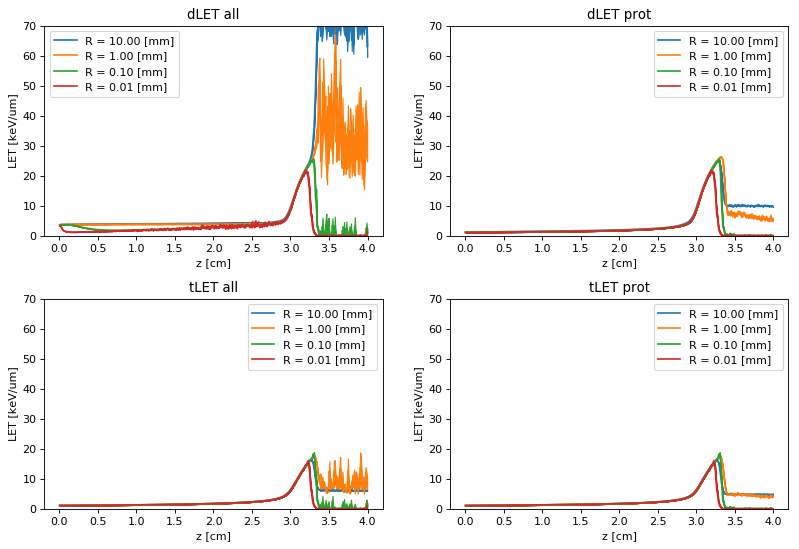

In [5]:
f, axes = plt.subplots(2,2,figsize=(12, 8), dpi=80)
for ax,(a,f) in zip(axes.flatten(),product(ave_metadata, filter_metadata)):
    plt.subplots_adjust(hspace = .3)
    for r in radius_metadata:
        ax.set_ylim(0,70)
        ax.set_title('{:s}LET {:s}'.format(a,f))
        cut = (data['ave']==a) & (data['fil']==f) & (data['rad']==r)
        plot_with_error_band(ax, data['x'][cut], data['y'][cut], data['e'][cut], label="R = {:4.2f} [mm]".format(r))
    ax.legend(loc=0)

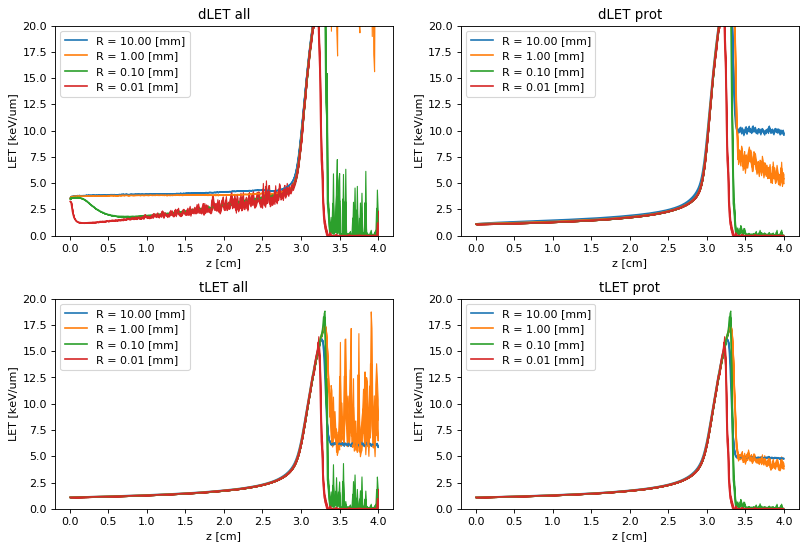

In [6]:
f, axes = plt.subplots(2,2,figsize=(12, 8), dpi=80)
for ax,(a,f) in zip(axes.flatten(),product(ave_metadata, filter_metadata)):
    plt.subplots_adjust(hspace = .3)
    for r in radius_metadata:
        ax.set_ylim(0,20)
        ax.set_title('{:s}LET {:s}'.format(a,f))
        cut = (data['ave']==a) & (data['fil']==f) & (data['rad']==r)
        plot_with_error_band(ax, data['x'][cut], data['y'][cut], data['e'][cut], label="R = {:4.2f} [mm]".format(r))
    ax.legend(loc=0)

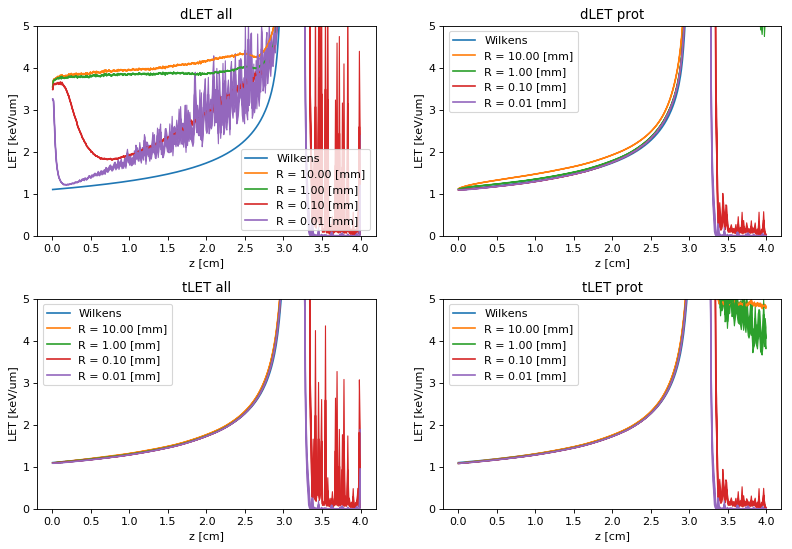

In [7]:
f, axes = plt.subplots(2,2,figsize=(12, 8), dpi=80)
for ax,(a,f) in zip(axes.flatten(),product(ave_metadata, filter_metadata)):
    plt.subplots_adjust(hspace = .3)
    if a == 't':
        let_keV_um = WilkensLET.let_t_keV_um(E_MeV, sigma_E_MeV, z_cm)
    else:
        let_keV_um = WilkensLET.let_d_keV_um(E_MeV, sigma_E_MeV, z_cm)
    ax.plot(z_cm, let_keV_um, label="Wilkens")
    for r in radius_metadata:
        ax.set_ylim(0,5)
        ax.set_title('{:s}LET {:s}'.format(a,f))
        cut = (data['ave']==a) & (data['fil']==f) & (data['rad']==r)
        plot_with_error_band(ax, data['x'][cut], data['y'][cut], data['e'][cut], label="R = {:4.2f} [mm]".format(r))
    ax.legend(loc=0)

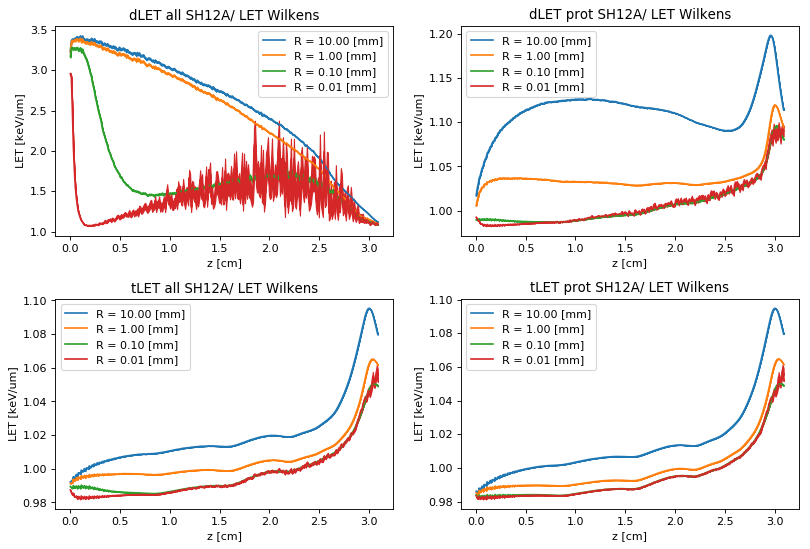

In [8]:
f, axes = plt.subplots(2,2,figsize=(12, 8), dpi=80)
for ax,(a,f) in zip(axes.flatten(),product(ave_metadata, filter_metadata)):
    plt.subplots_adjust(hspace = .3)
    if a == 't':
        let_keV_um = WilkensLET.let_t_keV_um(E_MeV, sigma_E_MeV, z_cm)
    else:
        let_keV_um = WilkensLET.let_d_keV_um(E_MeV, sigma_E_MeV, z_cm)
    for r in radius_metadata:
        ax.set_title('{:s}LET {:s} SH12A/ LET Wilkens'.format(a,f))
        cut = (data['ave']==a) & (data['fil']==f) & (data['rad']==r)
        plot_with_error_band(ax, data['x'][cut], data['y'][cut] / let_keV_um, data['e'][cut] / let_keV_um, label="R = {:4.2f} [mm]".format(r))
    ax.legend(loc=0)

## SHIELD-HIT12A configuration

In [9]:
!cat beam.dat

RNDSEED      	89736501     ! Random seed
JPART0       	2           ! Incident particle type
TMAX0      	60.0   0.5  ! Incident energy; (MeV/nucl)
NSTAT           10000    -1 ! NSTAT, Step of saving
! BEAMSIGMA       0.2  -0.2    ! enable to get broad beam emitted from disc with 2mm radius
STRAGG          2            ! Straggling: 0-Off 1-Gauss, 2-Vavilov
MSCAT           2            ! Mult. scatt 0-Off 1-Gauss, 2-Moliere
NUCRE           1            ! Nucl.Reac. switcher: 1-ON, 0-OFF
DELTAE          0.005



In [10]:
!cat detect.dat

*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0      10.0       7.0       4.0
                   1         1       400        -1      DOSE   d_cyl10
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0       0.1       7.0       4.0
                   1         1       400        -1      DOSE  d_cyl0p1
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0      0.01       7.0       4.0
                   1         1       400        -1      DOSE  d_cyl0p01
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0     0.001       7.0       4.0
                   1         1       400        -1      DOSE  d_cyl0p001
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
MSH             -0.1      -0.5       0.0       0.1       0.5       4.0
   

In [11]:
!cat mat.dat

MEDIUM 1
ICRU 276
LOADDEDX
END


In [12]:
!cat geo.dat

*---><---><--------><------------------------------------------------>
    0    0           H2O 30 cm cylinder, r=10, 1 zone
*---><---><--------><--------><--------><--------><--------><-------->
  RCC    1       0.0       0.0       0.0       0.0       0.0      30.0
                10.0
  RCC    2       0.0       0.0      -5.0       0.0       0.0      35.0
                15.0
  RCC    3       0.0       0.0     -10.0       0.0       0.0      40.0
                20.0
  END
  001          +1
  002          +2     -1
  003          +3     -2      
  END
    1    2    3
    1 1000    0

